In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.model_selection import learning_curve
import pandas as pd
import tensorflow as tf
import random
import os

In [74]:
# Garantir reprodutibilidade total
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [75]:
#Leitura de dados
df = pd.read_csv('data_per_month.csv')

df = df['Total Renewable Energy']

In [76]:
# Função para criar janelas de dados
def create_windows(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Função para remover outliers com base no método IQR
def remove_outliers(data):
    Q1 = np.percentile(data, 25, axis=0)  # Primeiro quartil
    Q3 = np.percentile(data, 75, axis=0)  # Terceiro quartil
    IQR = Q3 - Q1  # Intervalo interquartílico
    lower_bound = Q1 - 1.5 * IQR  # Limite inferior
    upper_bound = Q3 + 1.5 * IQR  # Limite superior
    
    # Filtra os dados para manter apenas os valores dentro dos limites
    return np.all((data >= lower_bound) & (data <= upper_bound), axis=1)

In [77]:
# Criar janelas de tamanho ajustado
window_size = 12
X, y = create_windows(df.values, window_size)

# Remover outliers dos dados
mask = remove_outliers(X)
X_filtered = X[mask]
y_filtered = y[mask]

# Dividir em conjuntos de treino, validação e teste
train_size = int(len(X_filtered) * 0.6)
val_size = int(len(X_filtered) * 0.2)

X_train, y_train = X_filtered[:train_size], y_filtered[:train_size]
X_val, y_val = X_filtered[train_size:train_size + val_size], y_filtered[train_size:train_size + val_size]
X_test, y_test = X_filtered[train_size + val_size:], y_filtered[train_size + val_size:]


In [78]:
# Normalizar os dados com MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [79]:
# Definir o modelo MLP ajustado
mlp = MLPRegressor(max_iter=1600)

# Definir o espaço de hiperparâmetros ajustado
param_grid = {
    'hidden_layer_sizes': [(12,16,16,4)],  # Configurações levemente mais complexas
    'activation': ['relu'],
    'solver': ['adam'],
    'batch_size': [16,32],
    'learning_rate': ['constant'],
    'alpha': [0.001,0.01]  # Regularização leve
}

# Configurar e executar o Grid Search com TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=1)
grid_result = grid.fit(X_train_scaled, y_train)

# Resultados
print("Melhores hiperparâmetros:", grid_result.best_params_)
print("Melhor pontuação (MSE):", grid_result.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Melhores hiperparâmetros: {'activation': 'relu', 'alpha': 0.001, 'batch_size': 16, 'hidden_layer_sizes': (12, 16, 16, 4), 'learning_rate': 'constant', 'solver': 'adam'}
Melhor pontuação (MSE): 0.2623430501344709


In [80]:
# Fazer previsões no conjunto de teste
y_pred = grid.predict(X_test_scaled)

# Calcular métricas de avaliação
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
std_deviation = np.std(y_test - y_pred)

# Previsões para treino, validação e teste
y_pred_train = grid.predict(X_train_scaled)
y_pred_val = grid.predict(X_val_scaled)

# Calcular métricas para treino
r2_train = r2_score(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

# Calcular métricas para validação
r2_val = r2_score(y_val, y_pred_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

# Gerar curvas de aprendizado
train_sizes, train_scores, val_scores = learning_curve(
    estimator=grid.best_estimator_,
    X=X_train_scaled,
    y=y_train,
    cv=tscv,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Calcular médias e desvios padrão
train_scores_mean = -train_scores.mean(axis=1)
val_scores_mean = -val_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_std = val_scores.std(axis=1)

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Calcular a proporção de previsões dentro do limiar
tolerance = 0.05
correct_predictions = np.abs(y_test - y_pred) <= (tolerance * np.abs(y_test))
accuracy = np.mean(correct_predictions) * 100  # Em porcentagem

R²: 0.6998
RMSE: 20.5764
Desvio Padrão entre Real e Preditos: 19.1006


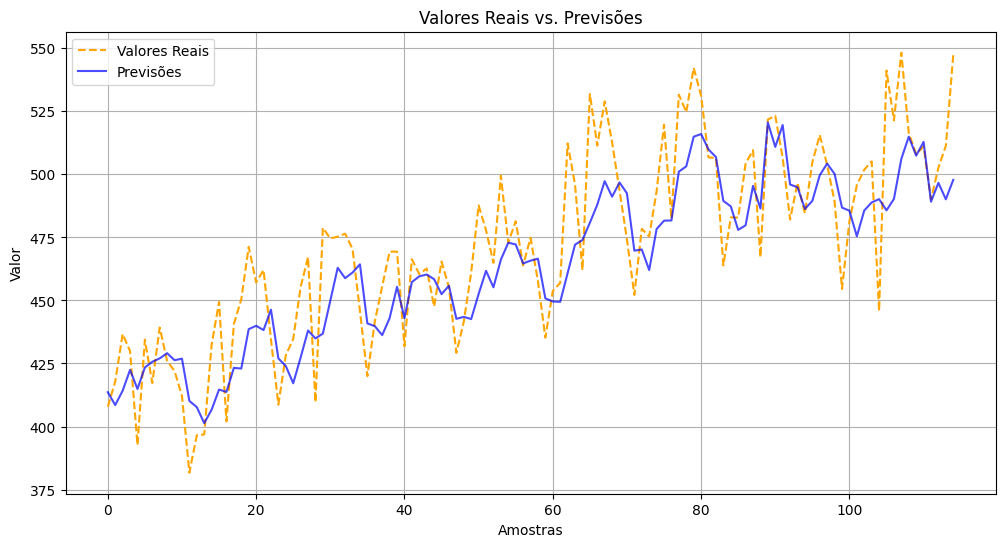

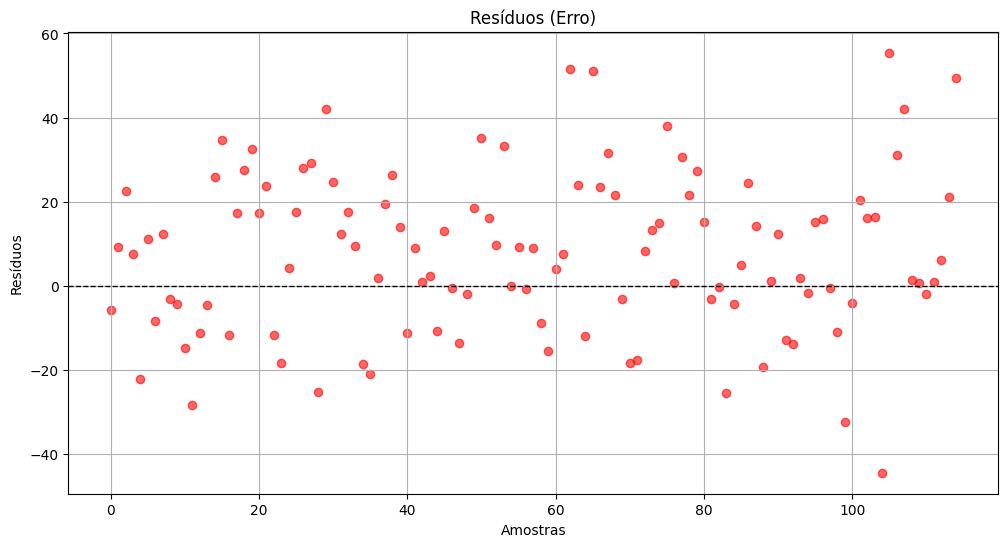

Métricas de Treino:
  R²: 0.8686
  RMSE: 17.1111

Métricas de Validação:
  R²: 0.8499
  RMSE: 15.6642

Métricas de Teste:
  R²: 0.6998
  RMSE: 20.5764
MAPE: 3.44%
Acurácia (dentro de 5% de tolerância): 74.78%


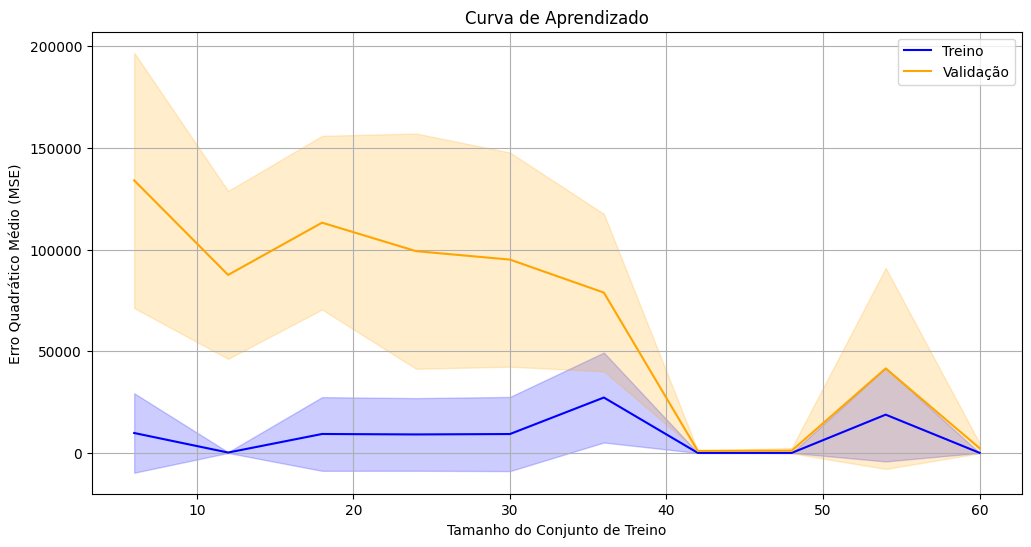

In [81]:
# Imprimir métricas de avaliação
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Desvio Padrão entre Real e Preditos: {std_deviation:.4f}")

# Plotar valores reais vs. preditos
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Valores Reais", color='orange', linestyle='--')
plt.plot(y_pred, label="Previsões", color='blue', alpha=0.7)
plt.xlabel("Amostras")
plt.ylabel("Valor")
plt.title("Valores Reais vs. Previsões")
plt.legend()
plt.grid()
plt.show()

# Plotar resíduos
residuals = y_test - y_pred
plt.figure(figsize=(12, 6))
plt.scatter(range(len(residuals)), residuals, color='red', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Amostras")
plt.ylabel("Resíduos")
plt.title("Resíduos (Erro)")
plt.grid()
plt.show()

# Imprimir métricas para todos os conjuntos
print("Métricas de Treino:")
print(f"  R²: {r2_train:.4f}")
print(f"  RMSE: {rmse_train:.4f}")

print("\nMétricas de Validação:")
print(f"  R²: {r2_val:.4f}")
print(f"  RMSE: {rmse_val:.4f}")

print("\nMétricas de Teste:")
print(f"  R²: {r2:.4f}")
print(f"  RMSE: {rmse:.4f}")

print(f"MAPE: {mape:.2f}%")
print(f"Acurácia (dentro de {tolerance * 100:.0f}% de tolerância): {accuracy:.2f}%")

# Plotar curvas de aprendizado
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_scores_mean, label="Treino", color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label="Validação", color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.xlabel("Tamanho do Conjunto de Treino")
plt.ylabel("Erro Quadrático Médio (MSE)")
plt.title("Curva de Aprendizado")
plt.legend()
plt.grid()
plt.show()
